In [1]:
!pip install biosignalsnotebooks

  Using cached numpy-1.22.2-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
Using cached numpy-1.22.2-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pywavelets 1.6.0 requires numpy<3,>=1.22.4, but you have numpy 1.22.2 which is incompatible.
statsmodels 0.14.2 requires numpy>=1.22.3, but you have numpy 1.22.2 which is incompatible.


In [2]:
!pip install statsmodels

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.2
    Uninstalling numpy-1.22.2:
      Successfully uninstalled numpy-1.22.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
biosignalsnotebooks 0.6.14 requires numpy==1.22.2, but you have numpy 1.24.4 which is incompatible.


In [3]:
!pip install PyWavelets

In [4]:
!pip install seaborn

In [5]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re
import pywt
from scipy.signal import firwin, lfilter
import biosignalsnotebooks as bsnb
# Scientific packages
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax
from scipy.integrate import cumtrapz
from scipy.signal import welch
import seaborn as sns
import re
import pywt
from scipy import signal
from scipy.signal import firwin, lfilter, iirnotch
from scipy.signal import find_peaks

MOSTRAR SEÑAL

Text(0.5, 1.0, 'Señal Original Reposo')

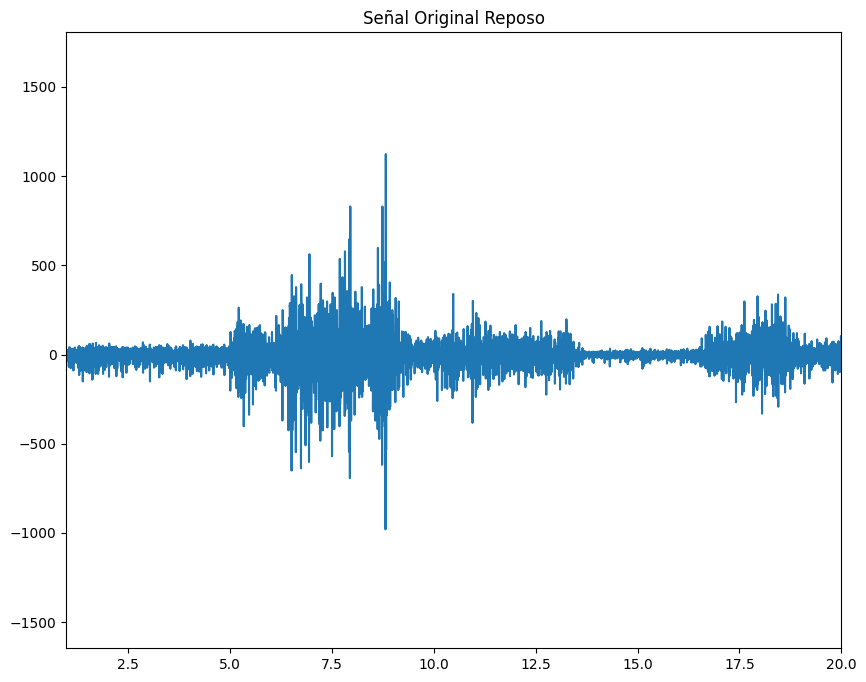

In [14]:
fs= 1000;
# Ruta al archivo de texto
archivo = 'Bruno.txt'

# Leer el archivo omitiendo las líneas de comentarios y el encabezado
data = pd.read_csv(archivo, delimiter='\t', comment='#', header=None)

# Extraer la sexta columna, que corresponde al índice 5 (los índices empiezan en 0)
amplitud = data.iloc[:, 5]

# Convertir los datos de la sexta columna a una lista de Python

# Convertir valores crudos a milivoltios
voltaje_por_unidad = 3.3 / 1023

x = amplitud * voltaje_por_unidad * 1000  # Conversión a mV
# Crear una lista para el eje X, que va desde 1 hasta el número de elementos en valores_y
n = np.arange(1, len(x) + 1)
ts=n/fs;

# Eliminamos linea de base
x = x - np.mean(x)
emgsignal_2 = x - np.mean(x)

time = bsnb.generate_time(x, fs)

plt.figure(figsize=(10, 8))

plt.subplot(1, 1, 1)
plt.plot(time, x, label='Señal Original')
plt.xlim(1,20)
plt.title('Señal Original Reposo')

FILTRADO DE LA SEÑAL 

Text(0.5, 1.0, 'Señal Original Reposo')

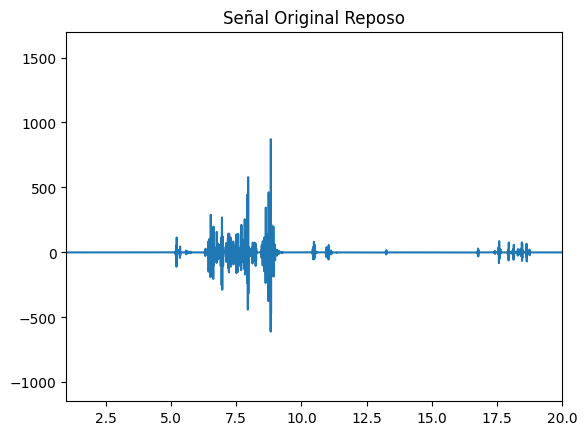

In [7]:

wavelet_db6 = 'db6'
level = 4

def denoise_signal(noisy_signal, wavelet, level):
    coeffs = pywt.wavedec(noisy_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(noisy_signal)))
    denoised_coeffs = list(map(lambda x: pywt.threshold(x, value=uthresh, mode='soft'), coeffs))
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal

denoised_signal_db6 = denoise_signal(emgsignal_2, wavelet_db6, level)

# Denoised signal (db6)
plt.subplot(1, 1, 1)
plt.plot(time, denoised_signal_db6, label='Señal filtrada')
plt.xlim(1,20)
plt.title('Señal Original Reposo')



Parameter Extraction

Detección de las contracciones musculares. 



In [8]:
# umbrales
mean_y = np.average(denoised_signal_db6)
std_y = np.std(denoised_signal_db6)

t_level1 = 1
t_l = mean_y + t_level1 *std_y
binary_signal = []
for i in range(0, len(time)):
    if denoised_signal_db6[i] >= t_l:
        binary_signal.append(1)
    else:
        binary_signal.append(0)
binary_signal = np.array(binary_signal)
binary_signal *= int(np.max(denoised_signal_db6))
bokeh_fig = bsnb.figure(x_axis_label="Tiempo(s)", y_axis_label="Amplitud")
bokeh_fig.line(time, binary_signal,line_color='red', legend_label="binary_signal")
bokeh_fig.line(time, denoised_signal_db6, legend_label="EMG data")

bsnb.show(bokeh_fig)

Detección de señales de activación

In [9]:
burst_begin, burst_end = bsnb.detect_emg_activations(denoised_signal_db6, fs, smooth_level=20, threshold_level=10, time_units=True, plot_result=True)[:2]

In [10]:
bsnb.emg_parameters(denoised_signal_db6, fs, raw_to_mv=False)

{'Number of Muscular Activations': 4,
 'Maximum Muscular Activation Duration': 1.9250546114783411,
 'Minimum Muscular Activation Duration': 0.23400663848619718,
 'Average Muscular Activation Duration': 1.0527798660954926,
 'Standard Deviation of Muscular Activation Duration': 0.7199709004337198,
 'Maximum Sample Value': 1569.6111564413407,
 'Minimum Sample Value': -1016.4849303559882,
 'Average Sample Value': -0.02578167401771597,
 'Standard Deviation Sample Value': 68.79232173681493,
 'RMS': 68.79232656798413,
 'Area': -908.8040091244753,
 'Total Power Spect': 4868.576194567736,
 'Median Frequency': 50.78125,
 'Maximum Power Frequency': 35.15625}

RMS

In [11]:
#Rectificamos la señal
emg_filtered_rectificada = np.abs(denoised_signal_db6)

# Media Movil
window_size = 500
i = 0
moving_averages = []
while i < len(emg_filtered_rectificada) - window_size + 1:
	window_average = round(np.sum(emg_filtered_rectificada[i:i+window_size]) / window_size, 2)
	moving_averages.append(window_average)
	i += 1

bokeh_fig = bsnb.figure(x_axis_label="Tiempo(s)", y_axis_label="Amplitud")
bokeh_fig.line(time, moving_averages, legend_label="Media móvil (RMS) de EMG")
bokeh_fig.title.text = "Gráfica RMS de EMG tras procesar la señal"

bsnb.show(bokeh_fig)

Segmentación

In [12]:
# Calcular media y desviación estándar
mean_emg = np.mean(denoised_signal_db6)
std_emg = np.std(denoised_signal_db6)

# Establecer el umbral
k = 2  # Número de desviaciones estándar sobre la media
threshold1 = mean_emg + k * std_emg

print("Threshold calculado:", threshold1)

Threshold calculado: 137.55886179961215


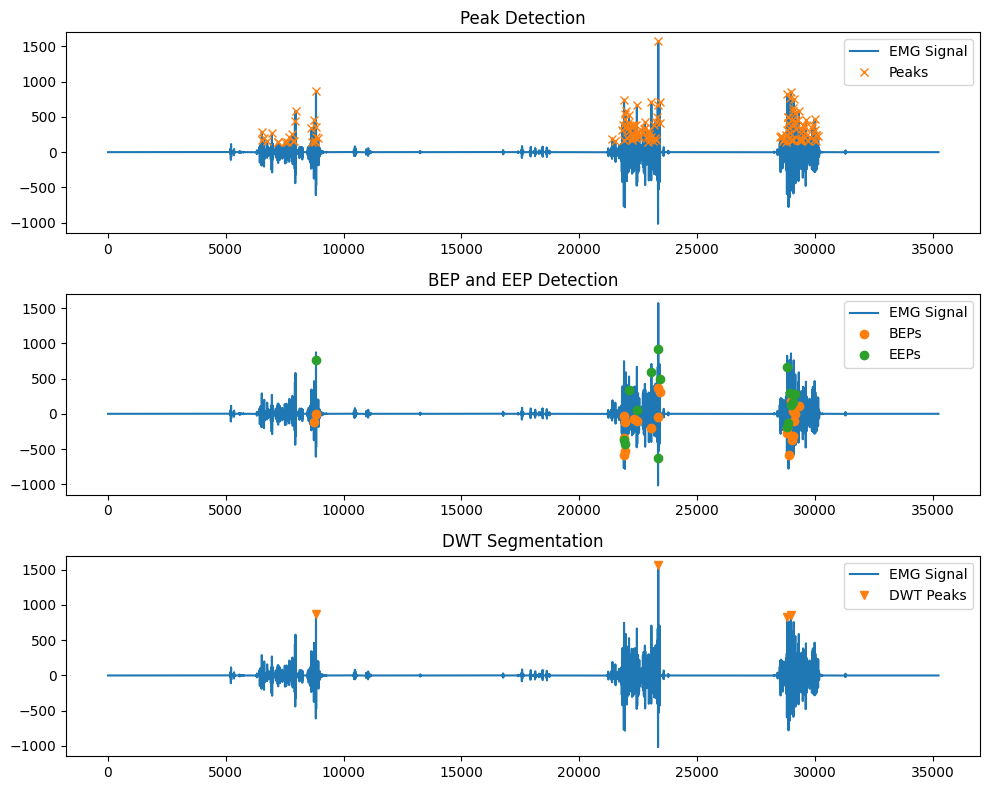

In [13]:




# 1. Identificación de picos de MUAPs
def peak_detection(emg_signal, threshold):
    peaks, _ = find_peaks(emg_signal, height=threshold)
    return peaks

# 2. Determinación de BEP y EEP
def find_bep_eep(emg_signal, window_size=50):
    derivative = np.diff(emg_signal)
    beps, _ = find_peaks(derivative, height=np.max(derivative)/2)
    eeps, _ = find_peaks(-derivative, height=np.max(-derivative)/2)
    return beps[:window_size], eeps[:window_size]

# 3. Segmentación usando DWT
def dwt_segmentation(emg_signal, wavelet='db4', level=1):
    coeffs = pywt.wavedec(emg_signal, wavelet, level=level)
    reconstructed_signal = pywt.waverec(coeffs, wavelet)
    peaks, _ = find_peaks(reconstructed_signal, height=np.max(reconstructed_signal)/2)
    return peaks


peaks = peak_detection(denoised_signal_db6, threshold1)
beps, eeps = find_bep_eep(denoised_signal_db6)
dwt_peaks = dwt_segmentation(denoised_signal_db6)

# Visualización en subplots
plt.figure(figsize=(10, 8))

# Picos de MUAPs
plt.subplot(3, 1, 1)
plt.plot(denoised_signal_db6, label='EMG Signal')
plt.plot(peaks, denoised_signal_db6[peaks], "x", label='Peaks')
plt.title('Peak Detection')
plt.legend()

# BEP y EEP
plt.subplot(3, 1, 2)
plt.plot(denoised_signal_db6, label='EMG Signal')
plt.plot(beps, denoised_signal_db6[beps], "o", label='BEPs')
plt.plot(eeps, denoised_signal_db6[eeps], "o", label='EEPs')
plt.title('BEP and EEP Detection')
plt.legend()

# DWT Peaks
plt.subplot(3, 1, 3)
plt.plot(denoised_signal_db6, label='EMG Signal')
plt.plot(dwt_peaks, denoised_signal_db6[dwt_peaks], "v", label='DWT Peaks')
plt.title('DWT Segmentation')
plt.legend()

plt.tight_layout()
plt.show()






